In [115]:
import pandas as pd, datetime as dt, matplotlib.pyplot as plt, numpy as np, streamlit as st, os, sys, nest_asyncio
import py_vollib_vectorized

from py_vollib.black_scholes import black_scholes
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes.greeks.analytical import delta

import datetime
%matplotlib inline 

In [116]:
# importing functions from the code base
base_path = os.path.abspath(os.path.join('..'))
print(base_path)
if base_path not in sys.path:
    sys.path.append(base_path)
    
import src.api as api

/Users/nicolas/Projects/crypto_option_dashboard


***
## 1) Enter Inputs

In [117]:
underlying = "BTC"  # Values can be 'BTC' or 'ETH'
desired_option_type = "Call"  # Values can be 'Call' or 'Put'

***
## 2) Identify the month-end option of the correct type for the chosen underlying

In [118]:
nest_asyncio.apply()
instruments = api.get_instruments(currency=underlying, kind="option", expired=False)
instruments.head(2)

,tick_size,taker_commission,strike,settlement_period,settlement_currency,rfq,quote_currency,option_type,min_trade_amount,maker_commission,...,instrument_name,instrument_id,expiration_timestamp,creation_timestamp,counter_currency,contract_size,block_trade_commission,base_currency,creation_time,expiration_time
0,0.0005,0.0003,30000.0,month,BTC,False,BTC,call,0.1,0.0003,...,BTC-24JUN22-30000-C,125666,1656057600000,1627994072000,USD,1.0,0.00015,BTC,2021-08-03 13:34:32,2022-06-24 09:00:00
1,0.0005,0.0003,45000.0,month,BTC,False,BTC,put,0.1,0.0003,...,BTC-25MAR22-45000-P,125665,1648195200000,1628197380000,USD,1.0,0.00015,BTC,2021-08-05 22:03:00,2022-03-25 08:00:00


#### 2)a) Identify what month we will be on in 3 days time

In [119]:
desired_month = (dt.datetime.now() + dt.timedelta(days=3)).month
datetime_object = datetime.datetime.strptime(str(desired_month), "%m")
month_name = datetime_object.strftime("%B")

print("In 3 days time we will be in month " + month_name)

In 3 days time we will be in month March


#### 2)b) Get the last expiry for that month  (that expiry will be on the last Friday of the month)

In [120]:
# Get the last option expiring on that month
expiry_dates = instruments.expiration_time.unique()
expiry_months = expiry_dates.astype('datetime64[M]').astype(int) % 12 + 1

month_end_expiry = np.datetime64(dt.datetime.now())

for i in range(0, len(expiry_dates)):
    if expiry_months[i] == desired_month and expiry_dates[i] > month_end_expiry:
        month_end_expiry =  expiry_dates[i]

print(month_end_expiry)

2022-03-25T08:00:00.000000000


#### 2)c) Get current spot (there are much better ways to do this)

In [121]:
temp = dt.datetime.now()
today_dt = dt.datetime(year=temp.year, month=temp.month, day=temp.day, hour=temp.hour, minute=temp.minute)

ts_today = today_dt.timestamp() * 1000
spot_ohlcv = api.get_historical_data(ts_today, ts_today, underlying + "-PERPETUAL", "1D")

spot = (spot_ohlcv['open'][0] + spot_ohlcv['close'][0] + spot_ohlcv['high'][0] + spot_ohlcv['low'][0]) / 4

print(spot)

40988.625


#### 2)d) Find the closest strike from the current spot among the ones available

In [122]:
desired_option_type = desired_option_type.lower()

strikes = instruments.loc[instruments['expiration_time'] == month_end_expiry].loc[instruments['option_type'] == desired_option_type].strike.unique()
desired_strike = min(strikes, key=lambda x:abs(x-spot))

print(desired_strike)

40000.0


#### 2)e) Isolate the data related to the option we are looking to backtest

In [123]:
instrument_data = instruments.loc[(instruments.expiration_time == month_end_expiry) 
                                  & (instruments.option_type == desired_option_type) 
                                  & (instruments.strike == desired_strike)]

instrument_data

,tick_size,taker_commission,strike,settlement_period,settlement_currency,rfq,quote_currency,option_type,min_trade_amount,maker_commission,...,instrument_name,instrument_id,expiration_timestamp,creation_timestamp,counter_currency,contract_size,block_trade_commission,base_currency,creation_time,expiration_time
193,0.0005,0.0003,40000.0,month,BTC,False,BTC,call,0.1,0.0003,...,BTC-25MAR22-40000-C,125019,1648195200000,1627994072000,USD,1.0,0.00015,BTC,2021-08-03 13:34:32,2022-03-25 08:00:00


***
## 3) Fetch Historical Data from the Deribit API

#### 3)a) Get data of both spot and option historical levels

In [124]:
ts_creation = dt.datetime.fromtimestamp(instrument_data["creation_timestamp"].values[0]/1000).replace(second = 0, microsecond = 0).timestamp() * 1000
ts_start = int((dt.datetime.now() + dt.timedelta(days=-60)).timestamp() * 1000)
ts_expiration = dt.datetime.fromtimestamp(instrument_data["expiration_timestamp"].values[0]/1000).replace(second = 0, microsecond = 0).timestamp() * 1000

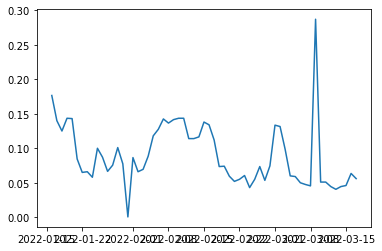

In [125]:
time_period = '1D'
option_data = api.get_historical_data(ts_start,
                                      ts_expiration,
                                      instrument_data["instrument_name"].iloc[0],
                                      time_period)
plt.plot(option_data['timestamp'], option_data['close'])

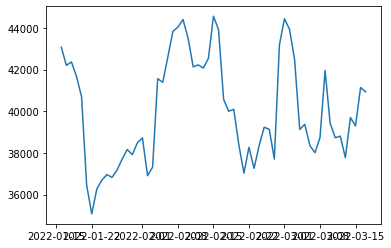

In [126]:
# For BTC the underlying will be 'BTC-PERPETUAL' while for ETH it will be 'ETH-PERPETUAL'
spot_data = api.get_historical_data(option_data.timestamp[0].timestamp() * 1000,
                                    ts_expiration,
                                    underlying + "-PERPETUAL",
                                    time_period)
plt.plot(spot_data['timestamp'], spot_data['close'])

#### Clean up option_data to remove stale prices

In [127]:
option_data.head()

,volume,ticks,status,open,low,high,cost,close,timestamp
0,0.0,1642291200000,ok,0.1765,0.1765,0.1765,0.00000,0.1765,2022-01-16
1,137.7,1642377600000,ok,0.1485,0.1400,0.1505,20.40180,0.1400,2022-01-17
2,14.7,1642464000000,ok,0.1350,0.1250,0.1380,1.96300,0.1250,2022-01-18
3,160.8,1642550400000,ok,0.1335,0.1335,0.1435,24.93020,0.1435,2022-01-19
4,364.5,1642636800000,ok,0.1375,0.1375,0.6370,204.29395,0.1430,2022-01-20


In [129]:
for index, row in option_data.iterrows():
    if index == 0:
        continue
    if row['volume'] == 0.0:
        days_to_expiry = (dt.datetime.fromtimestamp(ts_expiration / 1000) - dt.datetime.fromtimestamp(option_data['ticks'][index-1] / 1000)).days
        # Imply vol from previous_close
        implied_vol = implied_volatility(price=option_data['close'][index-1] * spot_data['close'][index-1],
                                         S=spot_data['close'][index-1],
                                         K=strike,
                                         t=days_to_expiry/365,
                                         r=r,
                                         flag=option_type, 
                                         return_as="series")
        # Calculate the current price based on previous_close's vol
        days_to_expiry = (dt.datetime.fromtimestamp(ts_expiration / 1000) - dt.datetime.fromtimestamp(option_data['ticks'][index] / 1000)).days
        option_data.loc[index, 'close'] = black_scholes(flag=option_type, 
                                                        S=spot_data['close'][index],
                                                        K=strike,
                                                        t=days_to_expiry/365,
                                                        r=r,
                                                        sigma=implied_vol[0],
                                                        return_as='numpy')[0] / spot_data['close'][index]
        print(option_data.loc[index, 'close'])

0.11106168296897882


#### 3)b) Combine option and spot data together in a dataframe

In [130]:
data = pd.merge(option_data, spot_data, how="left", on="ticks", suffixes=("_option","_spot"))

unwanted = data.columns[data.columns.str.startswith('Unnamed')]
data.drop(unwanted, axis=1, inplace=True)
data.drop(["timestamp_option","timestamp_spot"],axis=1, inplace=True)
data['timestamp'] = data.ticks.apply(lambda x:dt.datetime.fromtimestamp(x/1000))

In [131]:
# Express the price of the option in USD
data['close_option_usd'] = data.apply(lambda row: (row['close_option'] * row['close_spot']), axis=1)

#### 3)c) Set parameters for backtest

In [132]:
strike = desired_strike

if desired_option_type == 'call':
    option_type = 'c'
else:
    option_type = 'p'
expiry = month_end_expiry
r = 0.01 # This is the risk-free interest rate. For short-dated options it doesn't matter much
qty = 1
mult = 1
is_delta_hedged = True

data["time_to_expiry"] = data.timestamp.apply(lambda x:expiry-x)
data["days_to_expiry"] = data["time_to_expiry"].apply(lambda x: x.days)

***
## 4) Backtest

#### 4)a) Implied Volatility

In [148]:
data['close_spot'][43]

43193.0

In [144]:
spot_data['close'][43]

43193.0

In [145]:
option_data['close'][43]

0.0745

In [150]:
dt.datetime.fromtimestamp(1646006400000/1000)

datetime.datetime(2022, 2, 28, 0, 0)

In [140]:
data[43:]

,volume_option,ticks,status_option,open_option,low_option,high_option,cost_option,close_option,volume_spot,status_spot,...,close_spot,timestamp,close_option_usd,time_to_expiry,days_to_expiry,ivol_mid,delta_mid,daily_pnl_option,daily_pnl_spot,pnl
43,131.2,1646006400000,ok,0.0595,0.0535,0.0745,8.35785,0.0745,28984.549024,ok,...,43193.0,2022-02-28,3217.87850,25 days 08:00:00,25,NaN,NaN,1200.63425,2304.978487,-1883.371150
44,11.2,1646092800000,ok,0.0955,0.0955,0.1335,1.31865,0.1335,25749.128541,ok,...,44443.5,2022-03-01,5933.20725,24 days 08:00:00,24,0.746709,0.741934,2715.32875,NaN,NaN
45,12.5,1646179200000,ok,0.1335,0.1255,0.1345,1.64035,0.1315,7007.035644,ok,...,43923.5,2022-03-02,5775.94025,23 days 08:00:00,23,0.822792,0.712040,-157.26700,-385.805672,-1654.832478
46,63.9,1646265600000,ok,0.1255,0.0950,0.1255,7.12315,0.0985,10664.213768,ok,...,42465.5,2022-03-03,4182.85175,22 days 08:00:00,22,0.684970,0.671241,-1593.08850,-1038.154262,-2209.766716
47,56.9,1646352000000,ok,0.0875,0.0600,0.2490,4.99045,0.0600,7197.696235,ok,...,39130.0,2022-03-04,2347.80000,21 days 08:00:00,21,0.727665,0.485872,-1835.05175,-2238.925780,-1805.892687
48,48.6,1646438400000,ok,0.0590,0.0565,0.0595,2.87175,0.0590,7763.705064,ok,...,39374.5,2022-03-05,2323.09550,20 days 08:00:00,20,0.706263,0.496267,-24.70450,118.795601,-1949.392787
49,32.6,1646524800000,ok,0.0570,0.0455,0.0570,1.77785,0.0500,10527.189477,ok,...,38359.0,2022-03-06,1917.95000,19 days 08:00:00,19,0.744181,0.436929,-405.14550,-503.958730,-1850.579557
50,203.0,1646611200000,ok,0.0510,0.0425,0.0560,9.74225,0.0475,14231.767676,ok,...,38011.0,2022-03-07,1805.52250,18 days 08:00:00,18,0.775606,0.417950,-112.42750,-152.051304,-1810.955753
51,416.4,1646697600000,ok,0.0470,0.0430,0.0545,22.17240,0.0455,24927.783059,ok,...,38742.5,2022-03-08,1762.78375,17 days 08:00:00,17,0.688218,0.445254,-42.73875,305.730554,-2159.425057
52,185.7,1646784000000,ok,0.0490,0.0490,0.2870,14.34305,0.2870,43183.903993,ok,...,41955.5,2022-03-09,12041.22850,16 days 08:00:00,16,3.286615,0.660585,10278.44475,1430.600307,6688.419386


/Users/nicolas/miniconda3/envs/py38/lib/python3.8/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [43]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


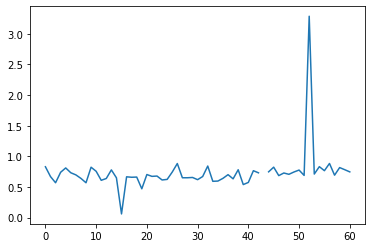

In [133]:
data['ivol_mid'] = implied_volatility(price=data['close_option_usd'],
                                      S=data['close_spot'],
                                      K=strike,
                                      t=data['days_to_expiry']/365,
                                      r=r,
                                      flag=option_type, 
                                      return_as="series")
plt.plot(data['ivol_mid'])

#### 4)b) Delta

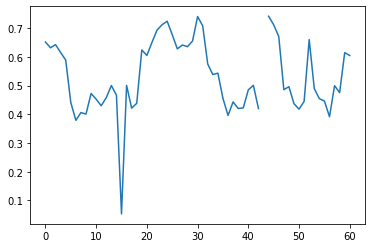

In [134]:
data['delta_mid'] = py_vollib_vectorized.greeks.delta(option_type, data['close_spot'], 
        strike,data['days_to_expiry']/365, r, data[ 'ivol_mid'])
plt.plot(data['delta_mid'])

#### 4)c) PnL

In [135]:
data['daily_pnl_option'] = data['close_option_usd'].diff() * qty * mult
data["daily_pnl_spot"] = data['close_spot'].diff() * data['delta_mid'].shift() * qty * mult
ts = data['daily_pnl_option'] - data["daily_pnl_spot"] * is_delta_hedged
data['pnl'] = ts.cumsum()

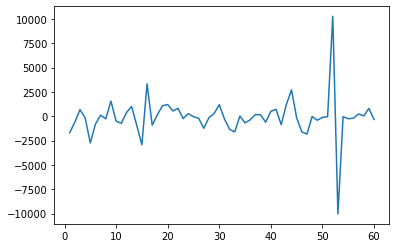

In [136]:
plt.plot(data['daily_pnl_option'])

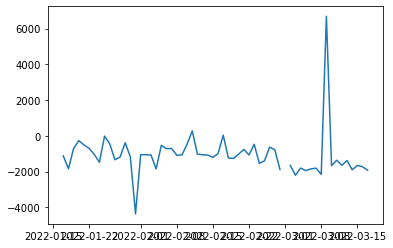

In [137]:
plt.plot(data['timestamp'],data['pnl']);

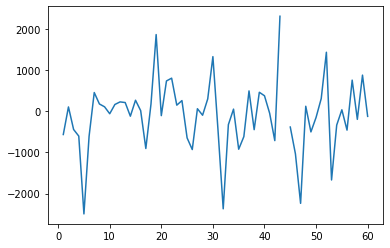

In [138]:
plt.plot(data["daily_pnl_spot"])